# Deliverables

### 1. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

**Automatize Data Ingestion**

In [6]:
%%writefile data_ingestion.py
#!/usr/bin/env python

import os
import re
import time
import numpy as np
import pandas as pd
from datetime import datetime

## Project directories
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join("data")
DEV = True
   
def _ingest_data(dev=DEV, verbose=True):
    """
    load, join and clean json invoice data
    """
    
    if dev:
        data_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"train")
    else:
        data_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"production")
    
    ## Check the data directory
    if not os.path.exists(data_dir):
        raise Exception("specified data dir does not exist")
    
    if not len(os.listdir(data_dir))>=1:
        raise Exception("specified data dir does not contain any files")
        
    ## create a list with all json files in the data directory
    if verbose:
        print("...reading from json files")
    json_files = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    
    ## read json file from the data directory
    total = len(json_files)
    if verbose:
        print("...{} json files in the '{}' directory".format(total, data_dir))
    aavail_data = {}
    for iteration,json_file in enumerate(json_files):
        if verbose:
            end = "" if (iteration+1) < total else "\n"
            print("\r...reading file: {}/{}".format(iteration+1,total), end=end)
        key = os.path.split(json_file)[-1]
        df = pd.read_json(json_file)
        aavail_data[key] = df
    
    ## default columns names
    column_names = ['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']
    
    ## rename columns to uniformly named features
    for invoice, df in aavail_data.items():
        if "StreamID" in df.columns.values:
            df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if "TimesViewed" in df.columns.values:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in df.columns.values:
            df.rename(columns={'total_price':'price'},inplace=True)
        if set(df.columns.values) != set(column_names):
            raise Exception("column names for {} could not be matched to correct columns".format(invoice))
    
    ## concatenate the data to one dataframe
    df = pd.concat(aavail_data, ignore_index=True)
    print("...concatenated to dataset of {} rows and {} columns".format(df.shape[0], df.shape[1]))
    
    ## Extract date from year, month and day
    df["invoice_date"] = pd.to_datetime(df[["year","month","day"]])

    ## invoice IDs should not contain any letters
    df["invoice_id"] = df["invoice"].str.replace(pat="\D+", repl="", regex=True).values.astype(np.int)
    df.drop(["invoice"], axis=1, inplace=True)
    
    return df

def _convert_to_ts(df, country=None):
    """
    convert the original clean dataframe to a time series
    by aggregating over each day for the given country
    """
    
    ## define the columns to group
    if country:
        cols = ["invoice_date", "country"]
    else:
        cols = ["invoice_date"]
        
    ## group the data    
    grouped = df.groupby(cols)
    
    ## count the purchases
    df_count = grouped[["price"]].count()
    df_count.rename(columns={'price':'purchases'},inplace=True)
    
    ## apply aggregation functions
    df_aggr = grouped.agg({"invoice_id":"nunique","stream_id": "nunique","times_viewed":"sum","price":"sum"})
    df_aggr.rename(columns={"invoice_id":"unique_invoices","stream_id":"unique_streams","times_viewed":"total_views","price":"revenue"}, inplace=True)
    
    ## merge the counts and the results from aggregation
    df_final = df_count.merge(df_aggr, left_index=True, right_index=True).reset_index()
    
    if country:
        mask = df_final.country == country
        return df_final[mask].drop("country", axis=1).set_index("invoice_date")
    else:
        return df_final.set_index("invoice_date")
    
def ingest_ts(clean=True, dev=DEV, verbose=True):
    """
    fetch timeseries data
    if the csv files exist, it reads from the file directory,
    otherwise it creates them from the original data and saves the files
    """
    
    if verbose:
        print("Ingesting Data")
    
    if dev:
        ts_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"train-ts")
    else:
        ts_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"production-ts")
        
    ## Check the data directory
    if not os.path.exists(ts_dir):
        os.makedirs(ts_dir)
        
    if (len(os.listdir(ts_dir)) > 0) & (clean == False):
        if verbose:
            print("...loading timeseries data from files")
        ts_files = [os.path.join(ts_dir,f) for f in os.listdir(ts_dir) if re.search("\.csv",f)]
        return {re.sub("\.csv","",os.path.split(f)[-1]):pd.read_csv(f, index_col=0) for f in ts_files}
        
    ## Load original data
    df = _ingest_data(dev=dev, verbose=verbose)
    

    ## Find the top ten countries by revenue
    top_10_countries = df.groupby("country")[["price"]].sum().sort_values(by="price",ascending=False)[:10].index.values.tolist()
    
    ## Add total to the countries
    countries = top_10_countries
    countries.append("Total")
    
    ## Convert the data to timeseries
    ts = {}
    if verbose:
        print("...converting data to timeseries")
    for country in countries:
        
        key = re.sub("\s+","_",country.lower())
        if key == "total":
            ts[key] = _convert_to_ts(df)
        else:
            ts[key] = _convert_to_ts(df, country=country)
        
        ## write file
        csv_path = os.path.join(ts_dir,"{}.csv".format(key))
        ts[key].to_csv(csv_path, index=True)
        
    return ts

def load_feature_matrix(clean=False, dev=DEV, verbose=True):
    """
    load the clean dataset after ingestion
    """
    
    ## load the dataset
    ts = ingest_ts(clean=clean, dev=dev, verbose=verbose)
    
    if verbose:
        print("Creating Feature Matrix")
    
    df = pd.concat(ts, keys=ts.keys(), names=["country"]).reset_index()

    ## check the type of the invoice_date
    if df.dtypes["invoice_date"] != "datetime64[ns]":
        df["invoice_date"] = pd.to_datetime(df["invoice_date"])
        
    return df

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## ingest data
    ts = ingest_ts(dev=DEV)
    
    print("METADATA")
    for key, item in ts.items():
        print("...{} {}".format(key, item.shape))
    
    ## metadata
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")

Overwriting data_ingestion.py


In [7]:
%run data_ingestion.py

Ingesting Data
...reading from json files
...21 json files in the './data/train' directory
...reading file: 21/21


/mnt/c/Harish/IBM/Trainings/AI Academy/AI Workflow/CAPSTONE/git/Aavail/data_ingestion.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(aavail_data, ignore_index=True)


...concatenated to dataset of 815011 rows and 9 columns
...converting data to timeseries
METADATA
...singapore (6, 5)
...germany (359, 5)
...eire (293, 5)
...hong_kong (9, 5)
...total (495, 5)
...portugal (72, 5)
...netherlands (133, 5)
...norway (19, 5)
...united_kingdom (495, 5)
...france (285, 5)
...spain (104, 5)
...run time: 0:00:36
done


### 2. Investigate the relationship between the relevant data, the target and the business metric.

**Automatize Data Visualization**

In [12]:
%%writefile data_visualization.py
#!/usr/bin/env python

import re
import time
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

## import functions to load the data
from data_ingestion import load_feature_matrix
from data_ingestion import DEV

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


IMAGE_DIR = os.path.join(".","images")

def save_fig(fig_id, tight_layout=True, image_path=IMAGE_DIR):
    """
    save the image as png file in the image directory
    """
    
    ## Check the data directory
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    
    path = os.path.join(image_path, fig_id + ".png")
    print("...saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def create_plots(df):
    """
    create plots for data visualization
    """
    print("Creating Plots")
    
    ## Analyze Total revenues over time
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    table = df[df.country=="total"].set_index("invoice_date")[["revenue"]].resample("MS").sum()
    table.plot(ax=ax1)
    ax1.set_xlabel("months")
    ax1.set_ylabel("revenues")
    ax1.title.set_text("Monthly Revenue")
    save_fig("monthly_revenues")
    
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    df["year"] = df.invoice_date.dt.year
    table = df[df.country=="total"].set_index("invoice_date")[["revenue"]].resample("AS").sum()
    table.plot(kind='bar', stacked=False, ax=ax1, rot=0)
    ax1.set_xlabel("year")
    ax1.set_ylabel("revenue")
    ax1.title.set_text("Total revenue per Year")
    save_fig("yearly_revenues")
    
    ## Analyze revenues per country
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    table = pd.pivot_table(df[df.country!="total"], index = ['country'], columns=["year"],values = 'revenue', aggfunc="sum")
    table.plot(kind='bar', stacked=False, ax=ax1, rot=90)
    ax1.set_xlabel("country")
    ax1.set_ylabel("revenues")
    ax1.title.set_text("Revenues in the top 10 markets")
    save_fig("revenues_per_market")
    
    ## Analyze Revenues in UK compared to the Total
    mask = (df.country=="united_kingdom") | (df.country=="total")
    df_filter = df[mask].copy()
    df_filter.drop(["invoice_date", "year"], axis=1, inplace=True)
    
    # revenue correlation matrix
    fig = plt.figure(figsize=(8,8))
    num_features = ["purchases","unique_invoices","unique_streams","total_views","revenue"]
    corrmat = df_filter.corr()
    k = len(num_features) #number of variables for heatmap
    cols = corrmat.nlargest(k, 'revenue')['revenue'].index
    cm = np.corrcoef(df_filter[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    save_fig("correlations")

if __name__ == "__main__":
    
    run_start = time.time()
    
    df = load_feature_matrix(dev=DEV, clean=False)
    create_plots(df)
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")

Overwriting data_visualization.py


In [48]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 216 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 26.0 MB 159 kB/s eta 0:00:01     |████████████████████████████████| 25.9 MB 5.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
%run data_visualization.py

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Creating Plots
...saving figure monthly_revenues
...saving figure yearly_revenues
...saving figure revenues_per_market
...saving figure correlations
METADATA
...run time: 0:00:05
done


In [14]:
from IPython.display import Image
from data_ingestion import load_feature_matrix, ingest_ts, DEV

df = load_feature_matrix(dev=DEV, clean=False)
df.head(10)

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix


,country,invoice_date,purchases,unique_invoices,total_views,unique_streams,revenue
0,united_kingdom,2017-11-28,2953,154,12922,1291,13281.12
1,united_kingdom,2017-11-29,3217,125,13650,1389,13222.97
2,united_kingdom,2017-11-30,2911,144,15243,1318,12941.50
3,united_kingdom,2017-12-01,2443,100,11652,1221,9163.07
4,united_kingdom,2017-12-02,370,31,3101,263,1263.28
5,united_kingdom,2017-12-03,1888,87,8096,964,6229.11
6,united_kingdom,2017-12-04,2684,110,11202,1301,12189.79
7,united_kingdom,2017-12-05,2283,157,11906,1151,8892.27
8,united_kingdom,2017-12-06,2423,108,10071,1292,10886.99
9,united_kingdom,2017-12-07,2403,116,11572,1192,10651.38


Top ten rows of the clean dataset

In [15]:
import pandas as pd
ts = ingest_ts(dev=DEV,clean=False)
pd.DataFrame.from_dict({key:item.shape[0] for key, item in ts.items()},orient="index", columns=["datasize"])

Ingesting Data
...loading timeseries data from files


,datasize
netherlands,133
germany,359
spain,104
france,285
hong_kong,9
portugal,72
total,495
norway,19
united_kingdom,495
eire,293


In [16]:
df.describe()
##df.head()

,purchases,unique_invoices,total_views,unique_streams,revenue
count,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000
mean,710.518943,37.157709,3693.143172,383.147137,3409.970371
std,935.070557,45.923555,4564.985058,424.707965,8049.971721
min,1.000000,1.000000,0.000000,1.000000,-45645.329000
25%,22.000000,1.000000,175.000000,22.000000,83.617500
50%,76.000000,3.000000,677.000000,72.000000,301.055000
75%,1329.500000,73.000000,7032.750000,780.000000,5068.520000
max,7756.000000,219.000000,29374.000000,1596.000000,170304.180000


**Analyze Total revenues**

Let's plot the total revenues over time to get a better insight into the data. This will help to understand how total revenues developed over the last years. Remember the objective is to identify the main factors that influence revenues.

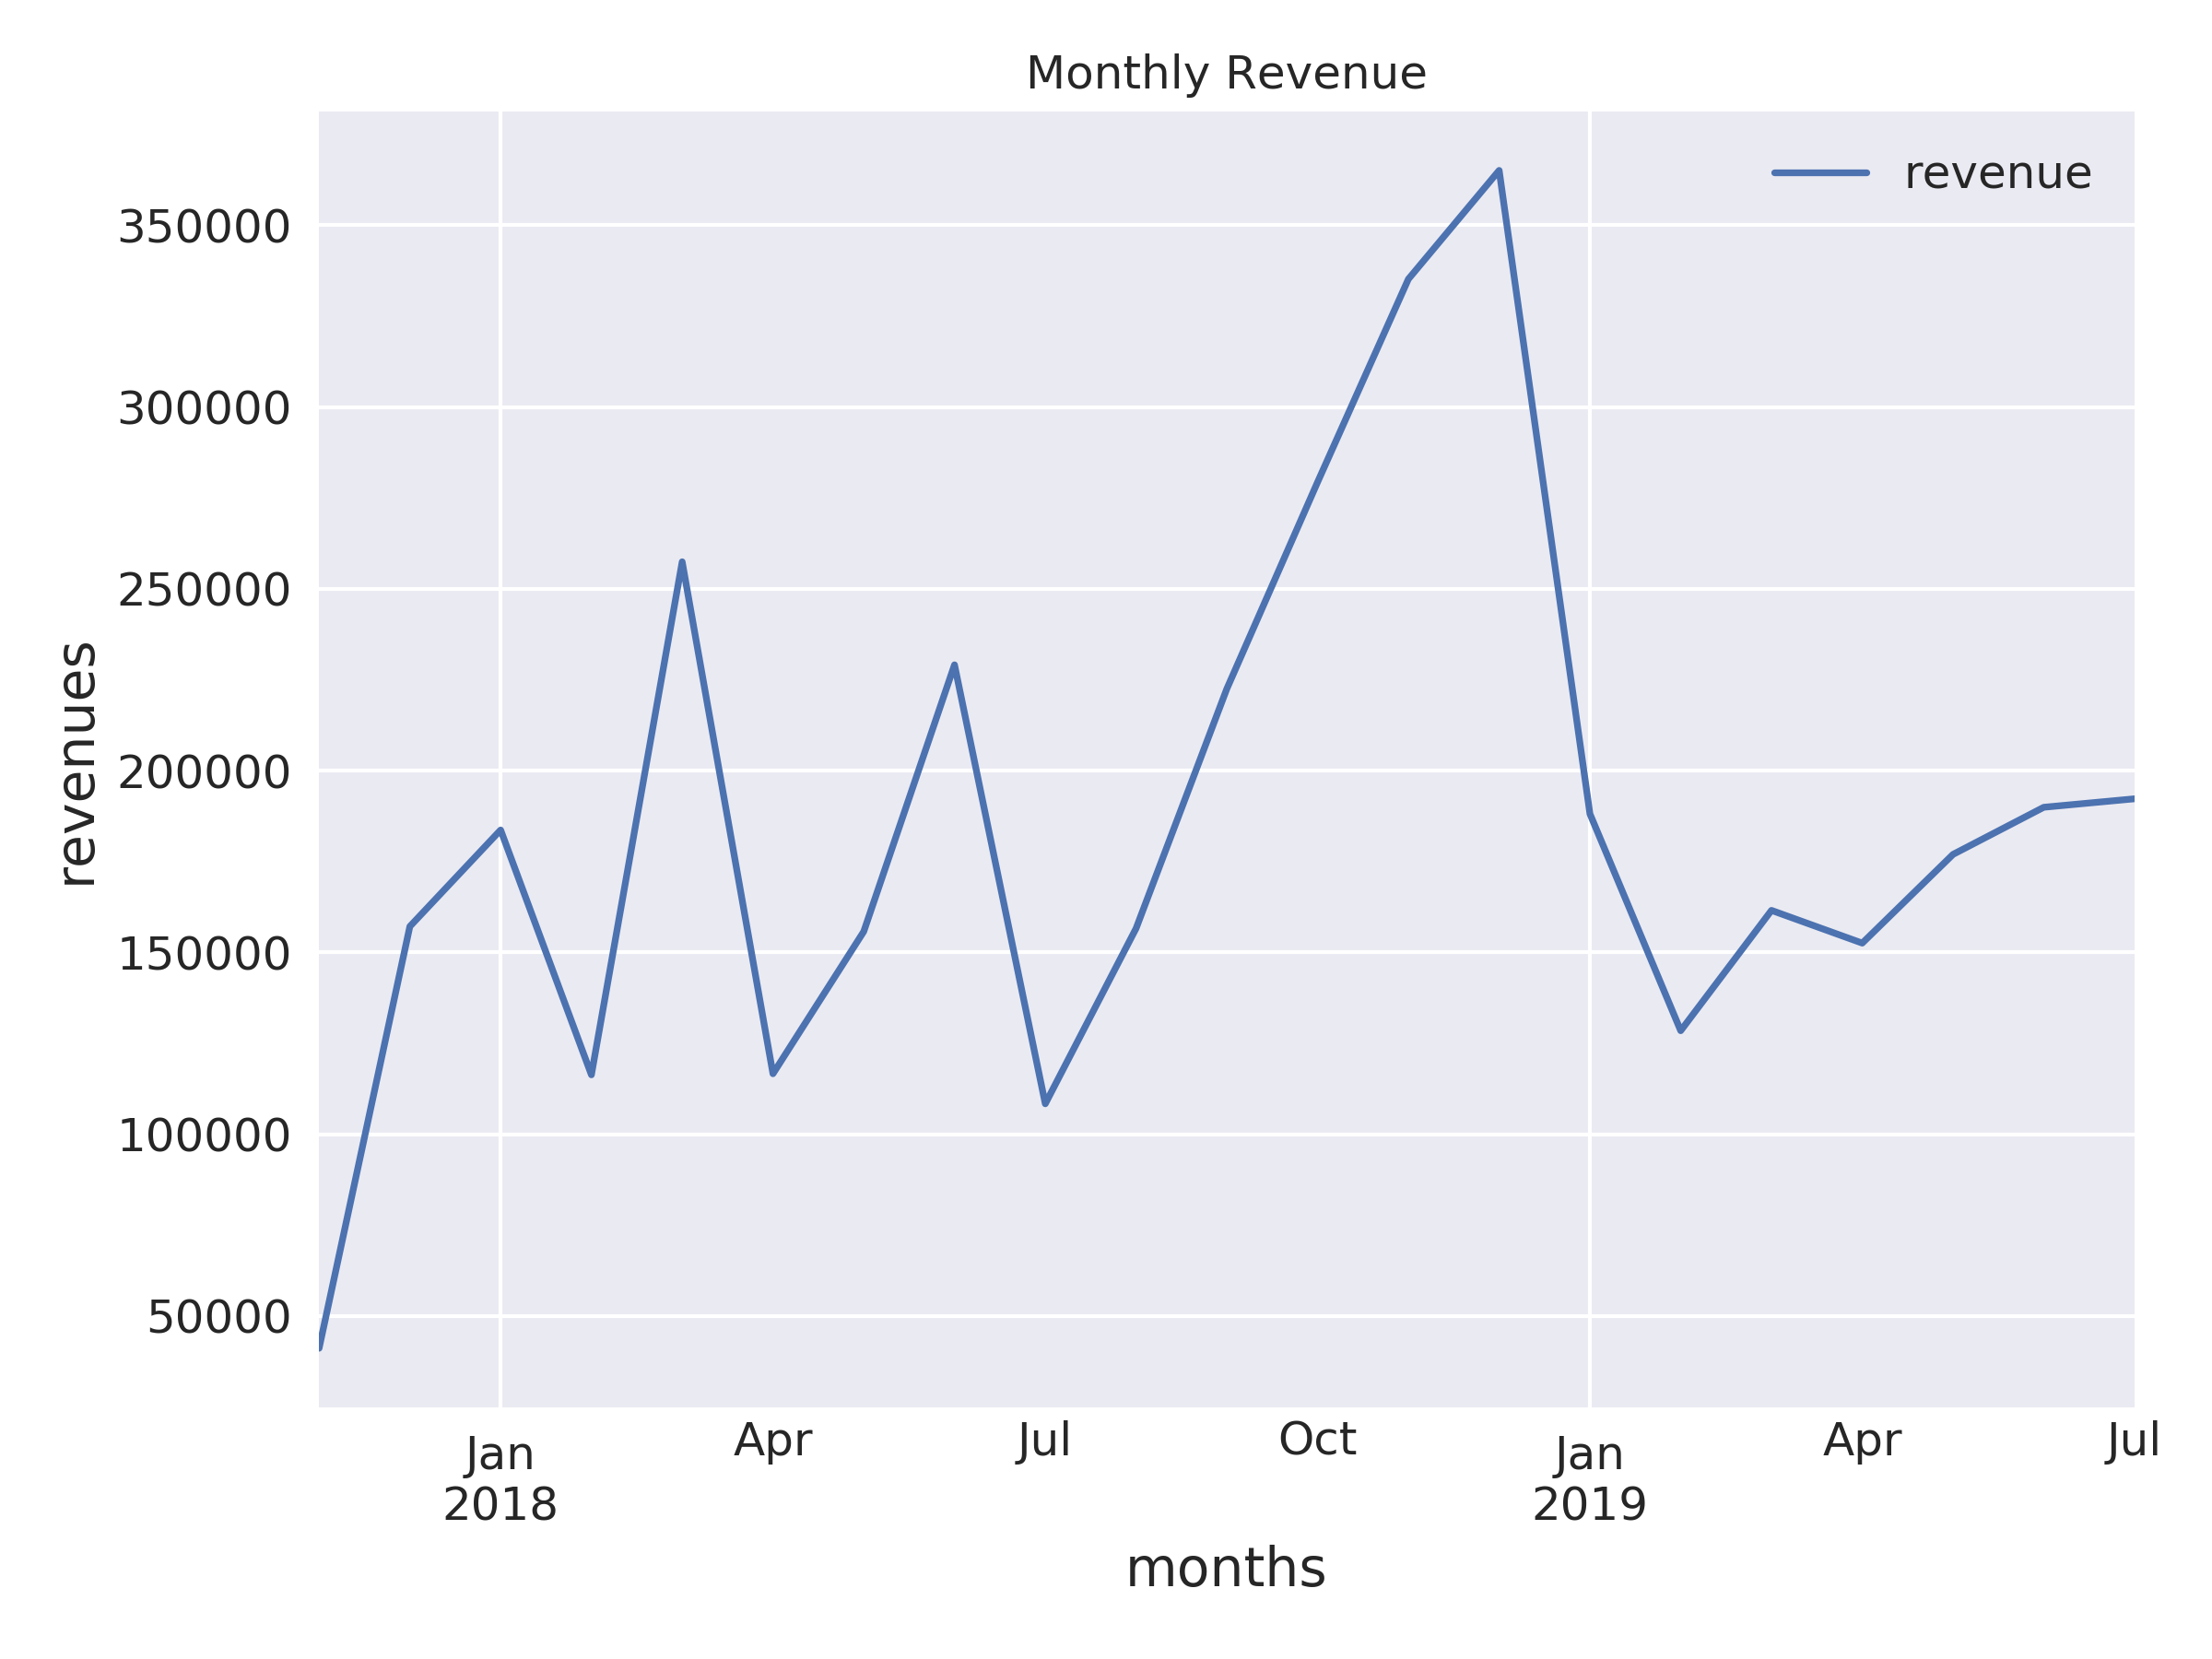

In [17]:
Image("./images/monthly_revenues.png",width=600,height=600)

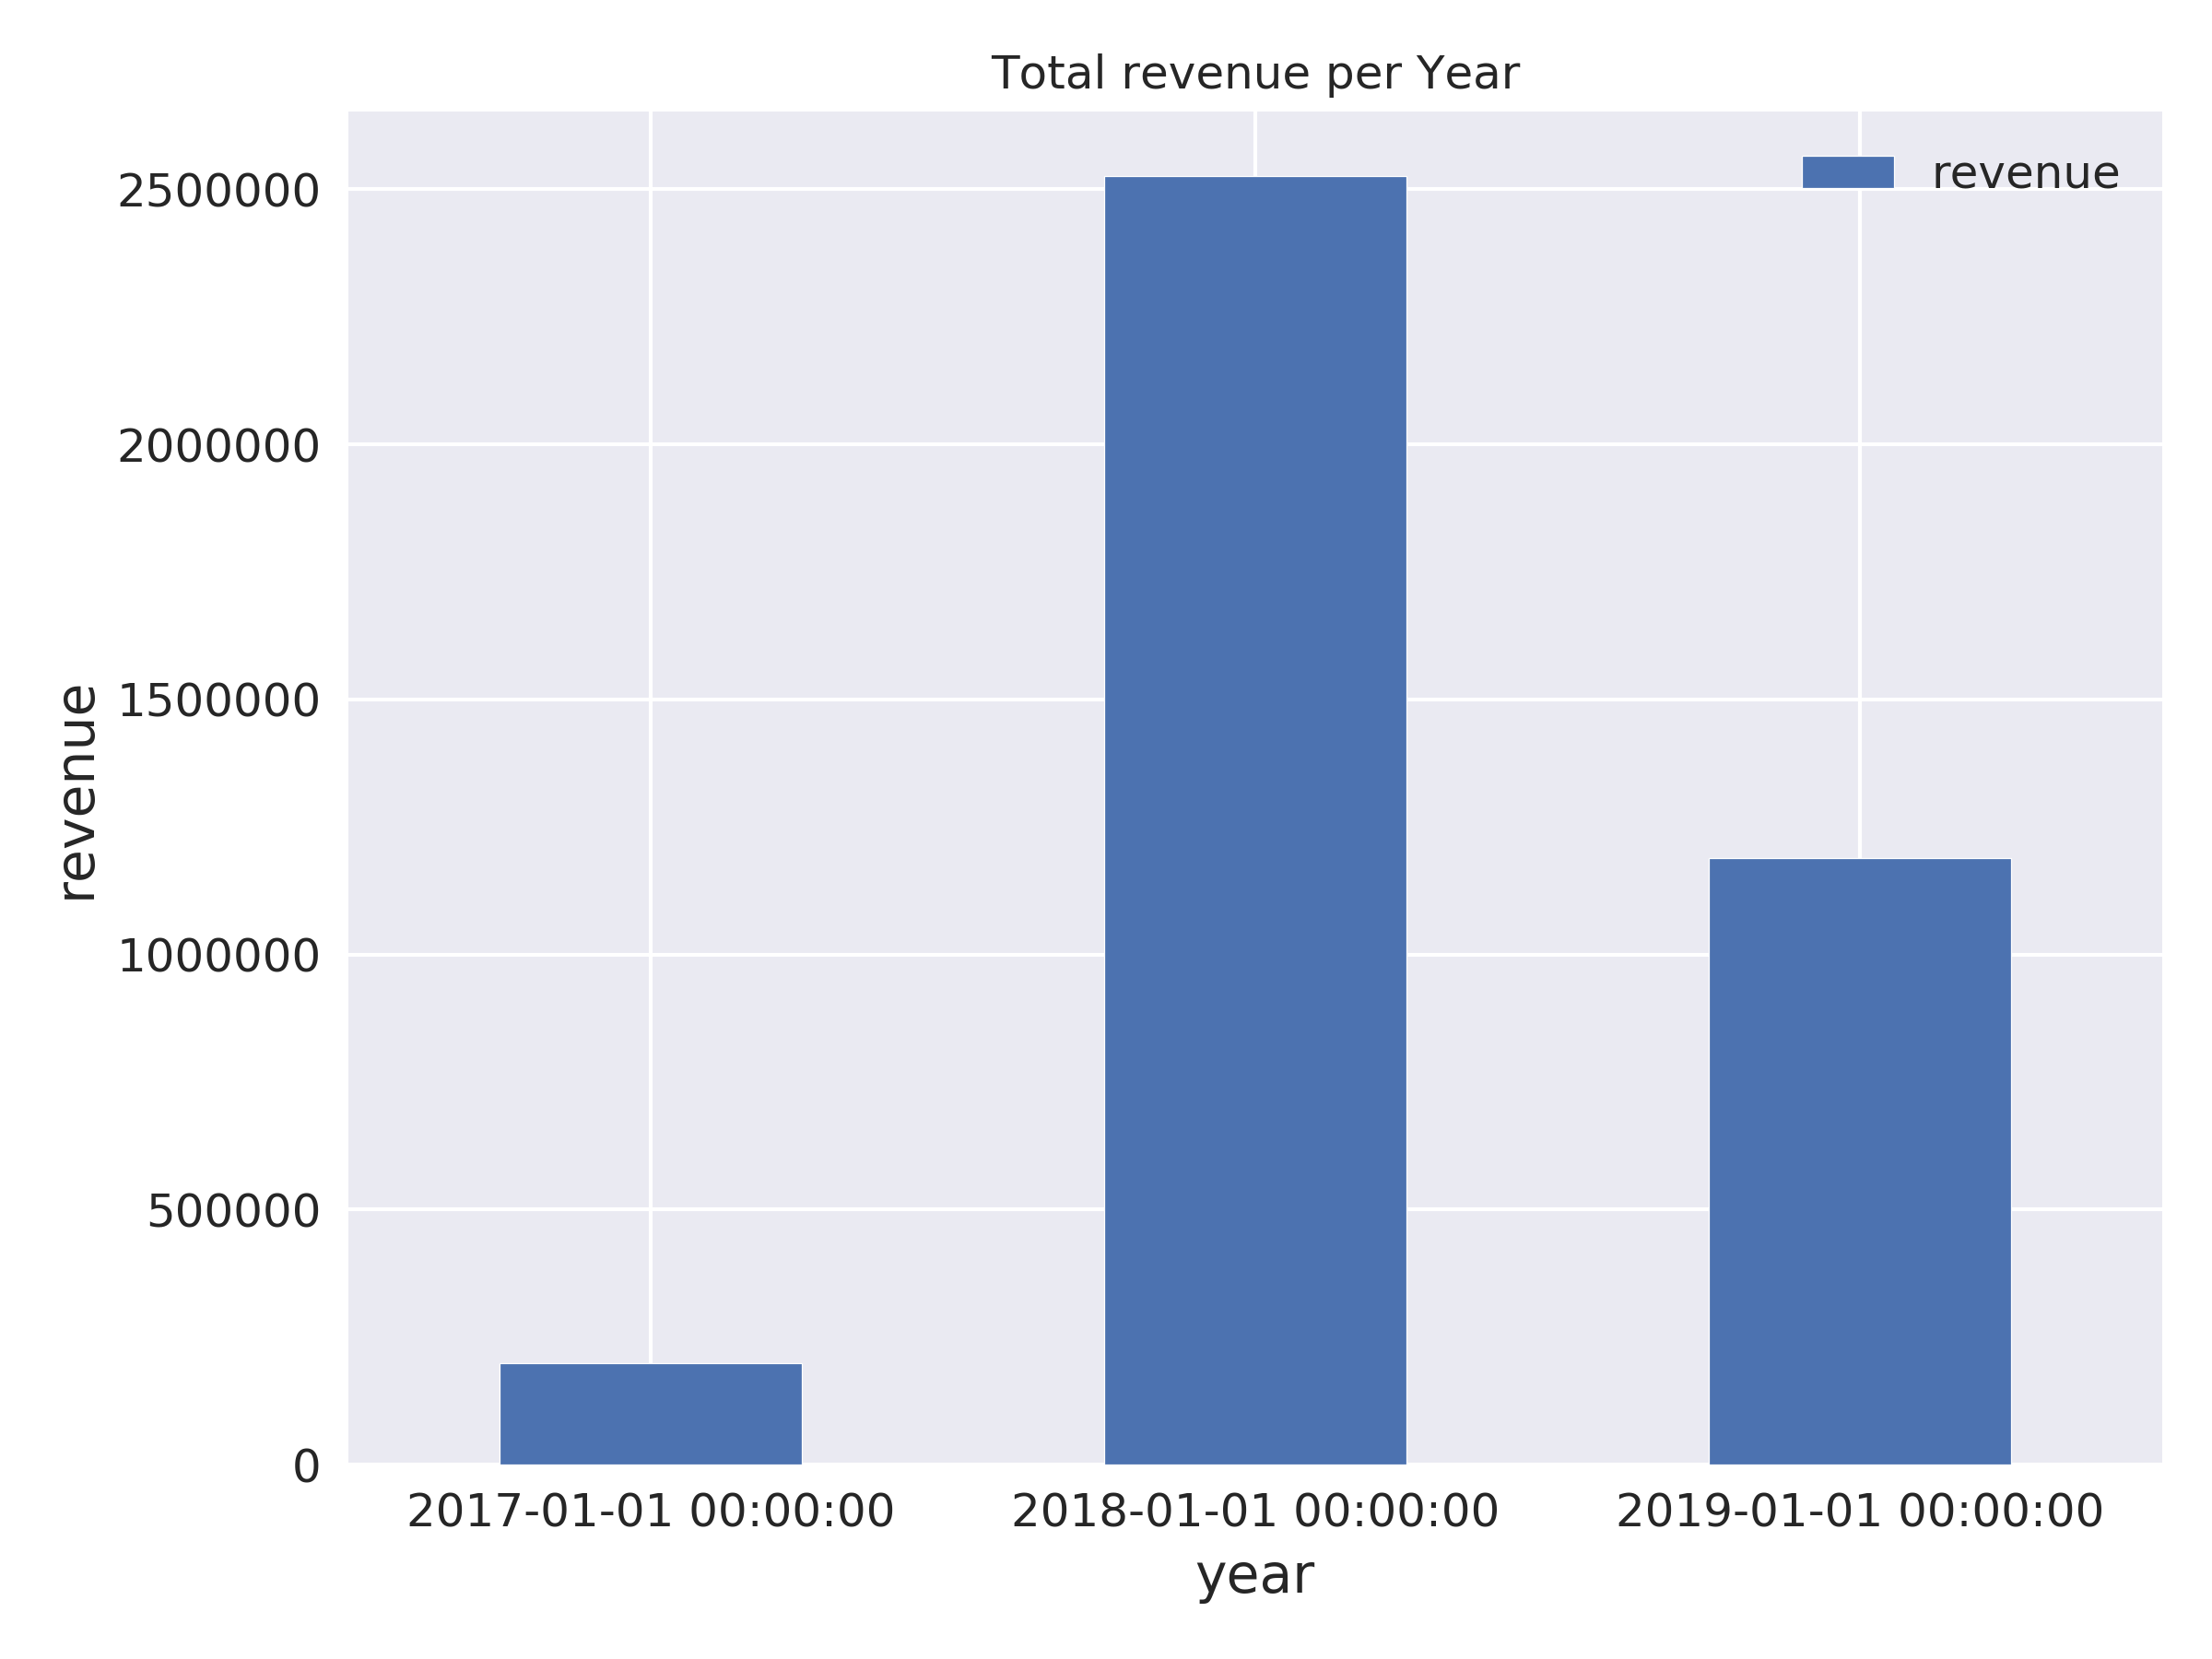

In [18]:
Image("./images/yearly_revenues.png",width=600, height=600)

**Analyze revenues per country**

We need to understand how the revenues developed for the top countries.

In [19]:
grouped = df.groupby("country")

total = grouped["revenue"].sum().sort_values(ascending=False).round(2)
percent = (grouped["revenue"].sum() / grouped["revenue"].sum().max()).sort_values(ascending=False).round(4)
revenues = pd.concat([total, percent], axis=1, keys=["Total","Percent"])
revenues[revenues.index!="total"]

,Total,Percent
country,,
united_kingdom,3521513.50,0.8997
eire,107069.21,0.0274
germany,49271.82,0.0126
france,40565.14,0.0104
norway,38494.75,0.0098
spain,16040.99,0.0041
hong_kong,14452.57,0.0037
portugal,13528.67,0.0035
singapore,13175.92,0.0034


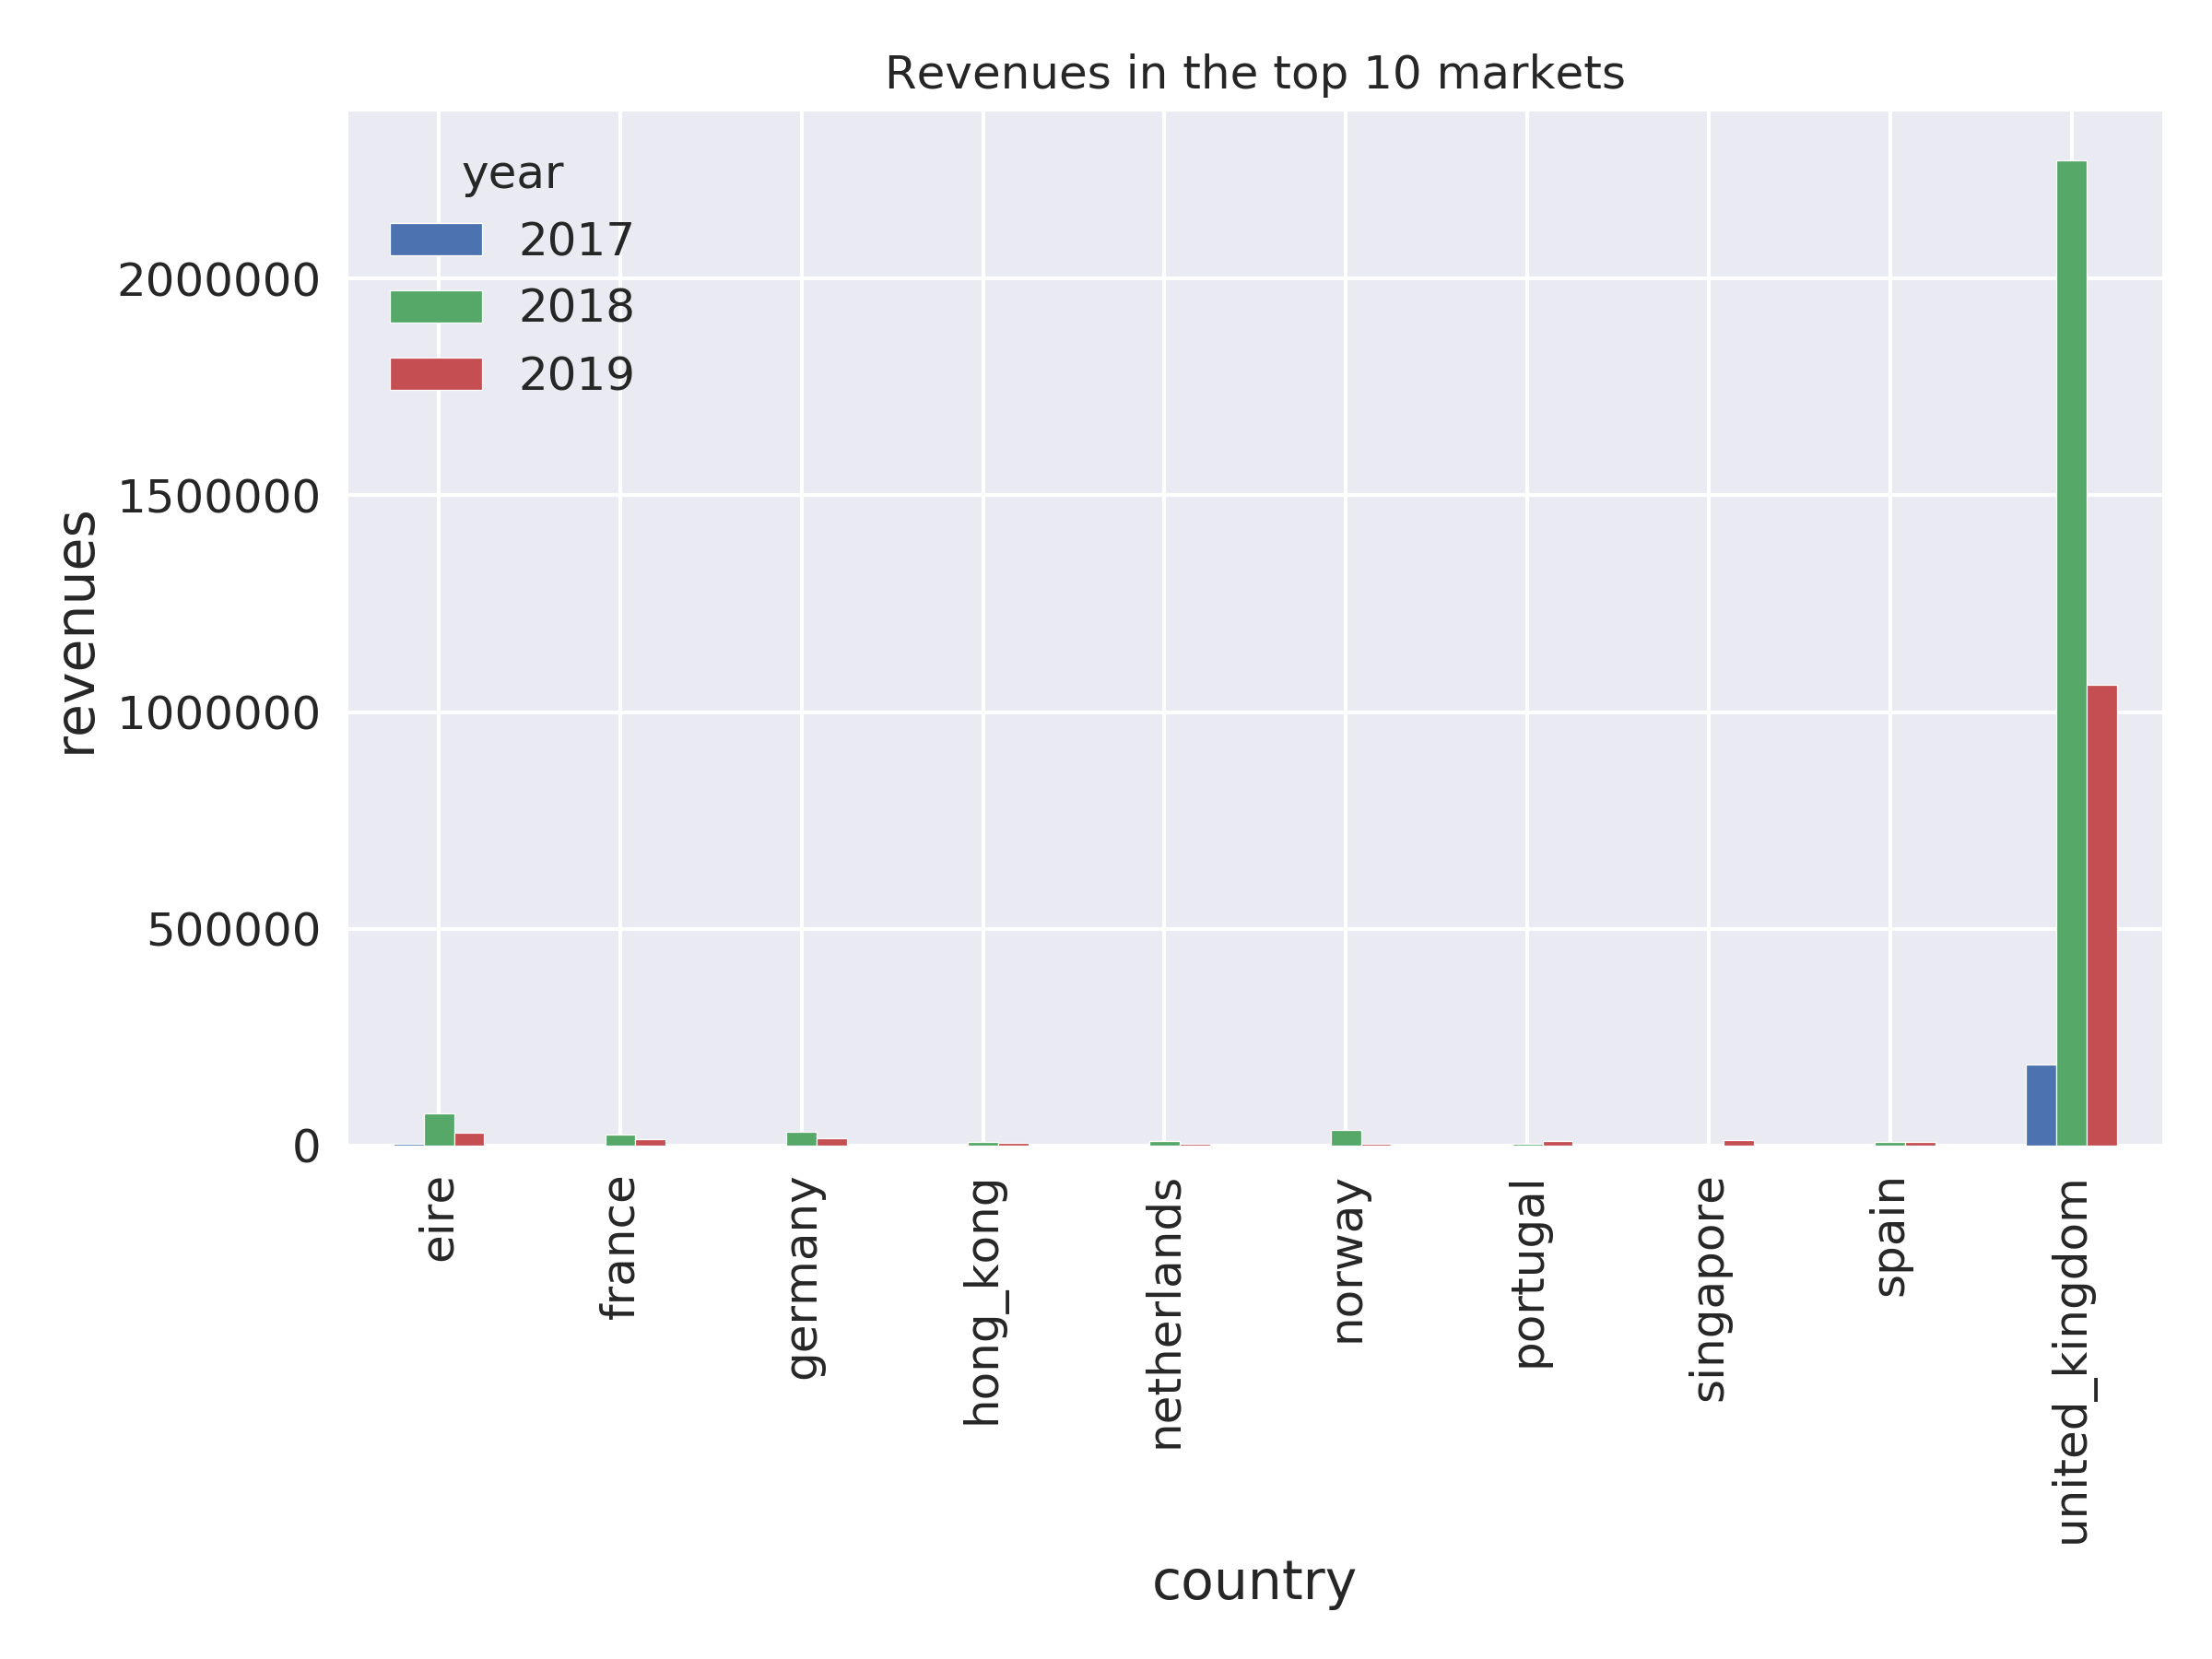

In [20]:
Image("./images/revenues_per_market.png",width=600, height=600)

* UK is the main revenue generating market with a share of almost 90%
* EIRE followed with a market share of 3%
* The other markets show significant low revenues.